# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.52KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

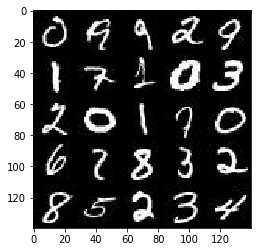

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

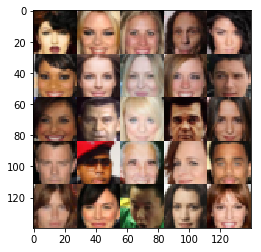

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     tf.reset_default_graph()
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 2.1293... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 2.0180... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 2.7466... Generator Loss: 0.2023
Epoch 1/2... Discriminator Loss: 2.5045... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 2.0384... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 1.6211
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 1.2405


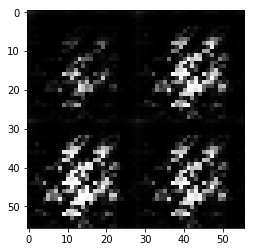

Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 0.5168... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 2.1245
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 1.6946


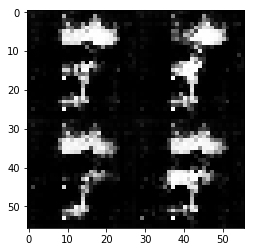

Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 1.3430
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.5958... Generator Loss: 1.4530
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.7083
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 1.4485


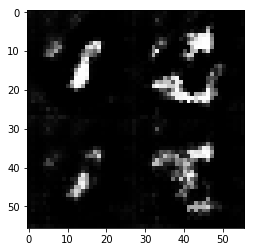

Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.9406
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.6458


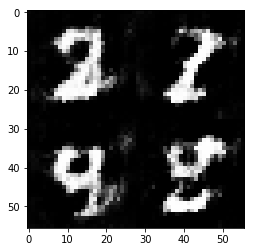

Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 1.5613... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 1.3612
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.4290
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 1.7020
Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.5209
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.8184


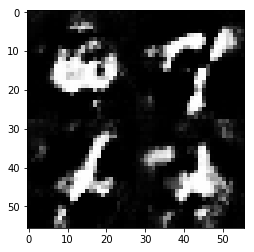

Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.2658
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8954
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 1.1701


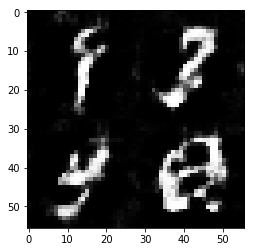

Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 1.1880
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 1.4144
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.4875
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.6212
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.5888


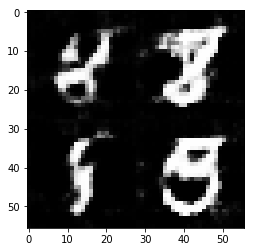

Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.3042
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7575


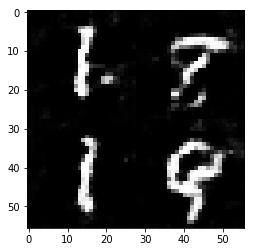

Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.3630
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.3665
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 1.0084


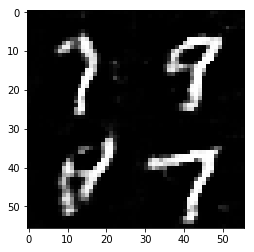

Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.5639
Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 1.3323
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.4923
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.8800


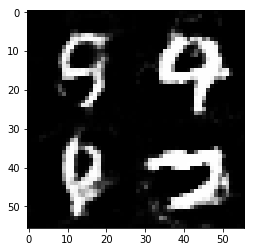

Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.4065... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.5153
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 1.5621... Generator Loss: 0.3112
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.5475


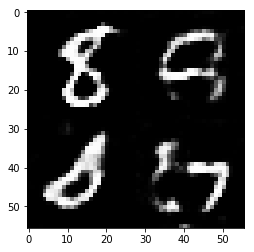

Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 1.2191
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 1.2268
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.6053... Generator Loss: 0.2918
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.4638


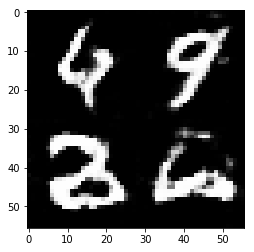

Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 1.1944
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.4982
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 1.2177


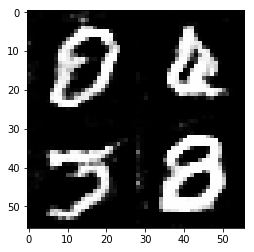

Epoch 2/2... Discriminator Loss: 1.5366... Generator Loss: 0.3180
Epoch 2/2... Discriminator Loss: 1.6123... Generator Loss: 0.2972
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 2.4662... Generator Loss: 1.6834
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.4938
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 1.0943


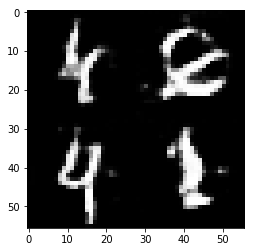

Epoch 2/2... Discriminator Loss: 1.5070... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.7038... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 0.3977
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.5969
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.3865


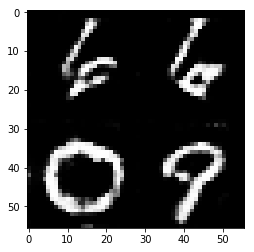

Epoch 2/2... Discriminator Loss: 1.6802... Generator Loss: 0.2857
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 2.1375... Generator Loss: 0.1498
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 2.6560... Generator Loss: 2.2440
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.7387


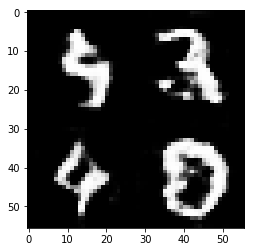

Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 1.7167
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.6874... Generator Loss: 0.2585
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.6295


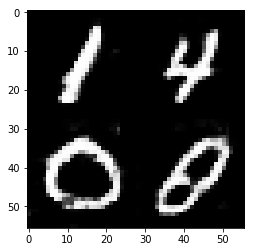

Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.5495... Generator Loss: 0.3276
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 1.2589
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.5531
Epoch 2/2... Discriminator Loss: 1.6998... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 1.4452... Generator Loss: 0.4159
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.6652


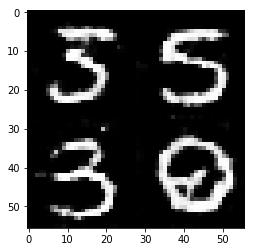

Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.5671... Generator Loss: 0.3177
Epoch 2/2... Discriminator Loss: 1.6371... Generator Loss: 0.2826
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.8510
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.5080


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.5699... Generator Loss: 0.0349
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 2.3506... Generator Loss: 0.2227
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.9818


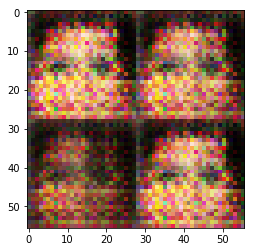

Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 2.3373... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.8018


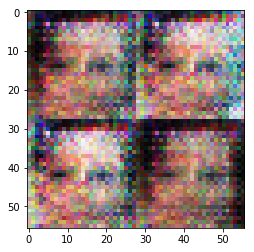

Epoch 1/1... Discriminator Loss: 1.8988... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 2.6281... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 2.3466... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.9949... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6961


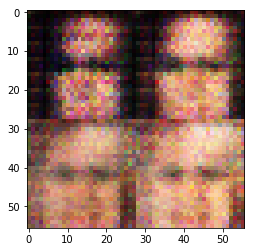

Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.7535


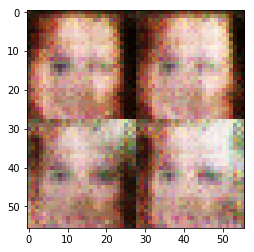

Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7193


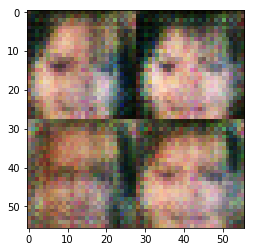

Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7095


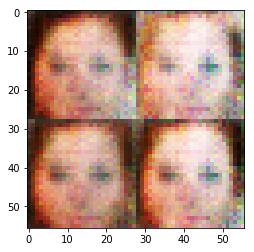

Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5813


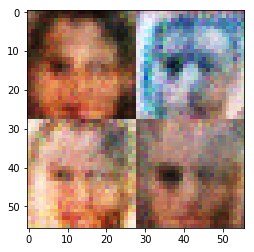

Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7001


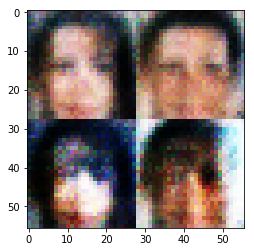

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7104


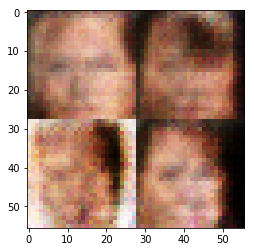

Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7075


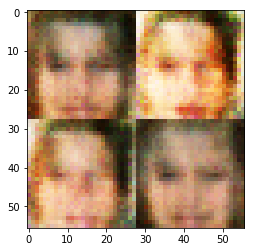

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6624


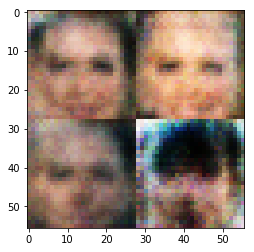

Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6857


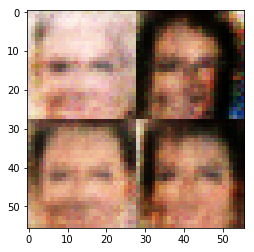

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6133


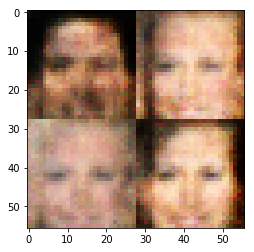

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.6551


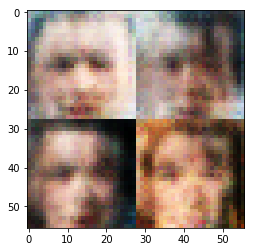

Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6136


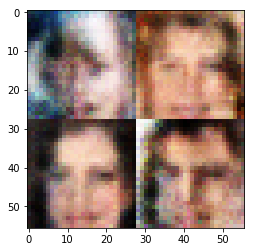

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6751


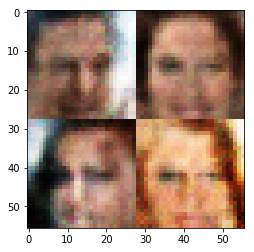

Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6531


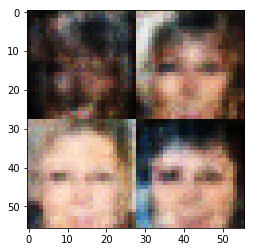

Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6501


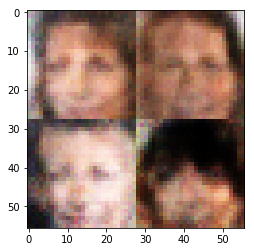

Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6607


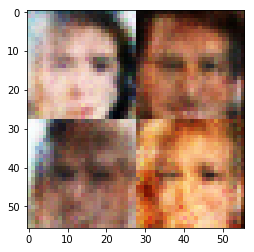

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6483


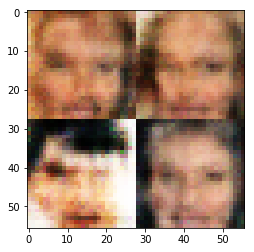

Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6502


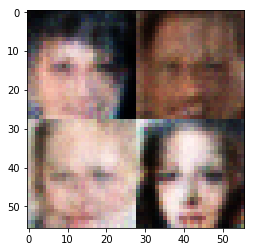

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5974


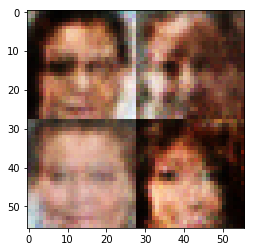

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7116


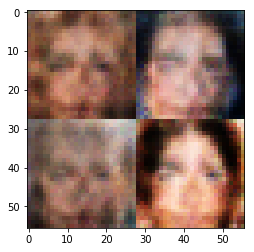

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6876


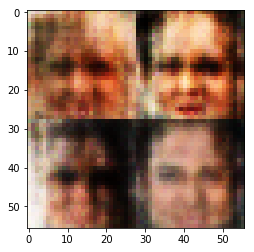

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6988


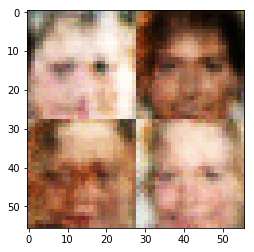

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6342


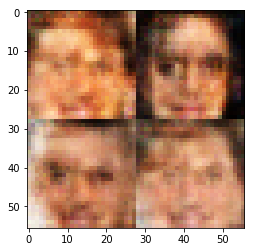

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6498


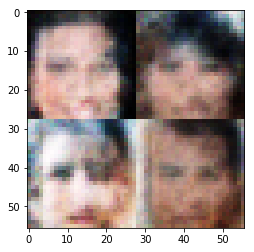

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6288


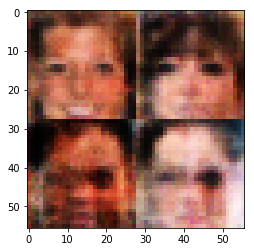

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6923


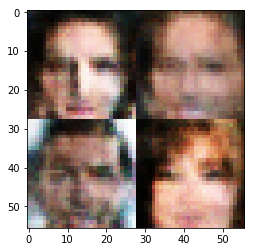

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6770


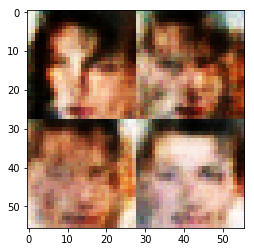

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6392


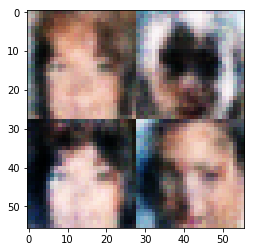

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6930


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.